# Линейная Регрессия: Обучение модели

В этом блокноте мы рассмотрим процесс построения и обучения модели линейной регрессии на реальных данных.
Будут применяться методы регуляризации, такие как Lasso и ElasticNet, чтобы предотвратить переобучение и улучшить качество модели.
Мы также визуализируем данные и оценим результаты с помощью различных метрик.

### Основные шаги:
1. Импортируем необходимые библиотеки и данные.
2. Выполним визуальный анализ данных с помощью Seaborn и Matplotlib.
3. Разделим данные на обучающую и тестовую выборки.
4. Применим модели линейной регрессии с регуляризацией.
5. Оценим качество моделей с помощью метрики  (RMSE).


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, ElasticNet  # Модели регрессии с регуляризацией
from sklearn.metrics import mean_squared_error  # Метрика оценки качества модели
from sklearn.model_selection import train_test_split, GridSearchCV  # Разделение данных и подбор гиперпараметров
from sklearn.preprocessing import StandardScaler  # Масштабирование данных
import numpy as np
from collections import Counter


# Загрузка данных

In [2]:
df = pd.read_csv('train.csv')


In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2209155,2,2016-05-03 09:03:08,2016-05-03 09:17:12,2,-73.979813,40.752529,-73.982681,40.763680,N,844
1,id0586605,1,2016-01-01 16:40:51,2016-01-01 16:57:32,1,-73.977623,40.746296,-73.968414,40.788933,N,1001
2,id0467144,1,2016-04-24 13:57:03,2016-04-24 14:14:31,1,-73.950699,40.779404,-73.863129,40.768608,N,1048
3,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784
4,id0580742,1,2016-02-25 17:37:36,2016-02-25 17:49:48,1,-73.967720,40.768742,-73.977173,40.789875,N,732


# Анализ

In [ ]:
df.isnull().sum()

,0
id,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0


Нету пропущенных значений

In [ ]:
df['vendor_id'].value_counts()

,count
vendor_id,
2,546566
1,474484


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1021050 non-null  object 
 1   vendor_id           1021050 non-null  int64  
 2   pickup_datetime     1021050 non-null  object 
 3   dropoff_datetime    1021050 non-null  object 
 4   passenger_count     1021050 non-null  int64  
 5   pickup_longitude    1021050 non-null  float64
 6   pickup_latitude     1021050 non-null  float64
 7   dropoff_longitude   1021050 non-null  float64
 8   dropoff_latitude    1021050 non-null  float64
 9   store_and_fwd_flag  1021050 non-null  object 
 10  trip_duration       1021050 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 85.7+ MB


In [3]:
df = df.drop('id', axis=1)

<Axes: xlabel='trip_duration', ylabel='Count'>

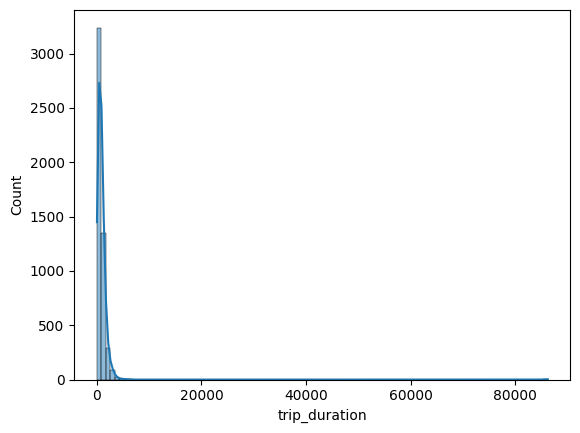

In [4]:
sns.histplot(data=df[:5000], x='trip_duration', bins=100, kde=True)

Распределение - логнормальное

In [5]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['day'] = df['pickup_datetime'].dt.day

df['pickup_hour'] = df['pickup_datetime'].dt.round('h').dt.hour

df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

df['month'] = df['pickup_datetime'].dt.month

df = df.drop(['dropoff_datetime', 'pickup_datetime'], axis=1)

Извлекаем из даты только день и час , год не учитываем так как он один и тот же

<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

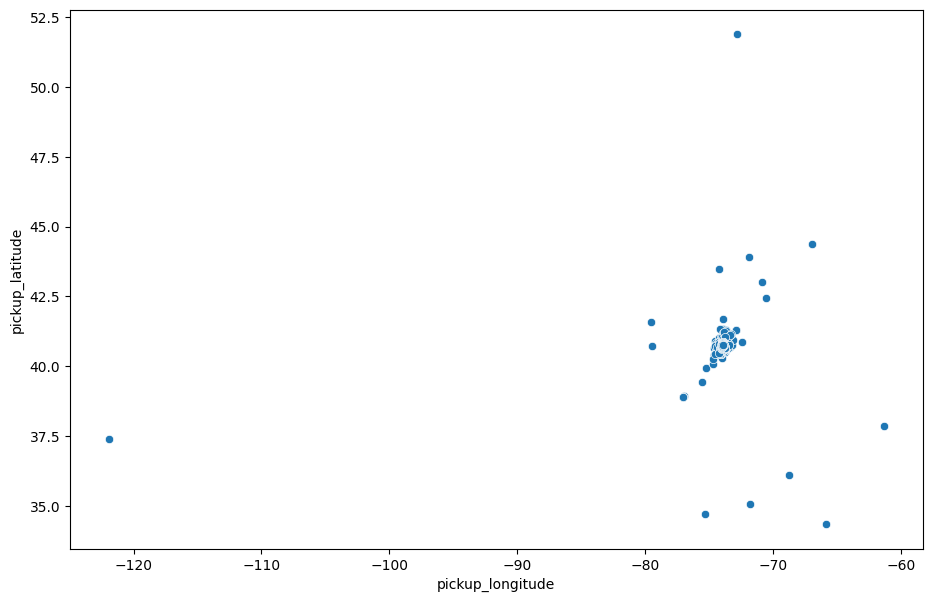

In [6]:
plt.figure(figsize=(11, 7))
sns.scatterplot(data=df, x='pickup_longitude', y='pickup_latitude')

<Axes: xlabel='dropoff_latitude', ylabel='dropoff_longitude'>

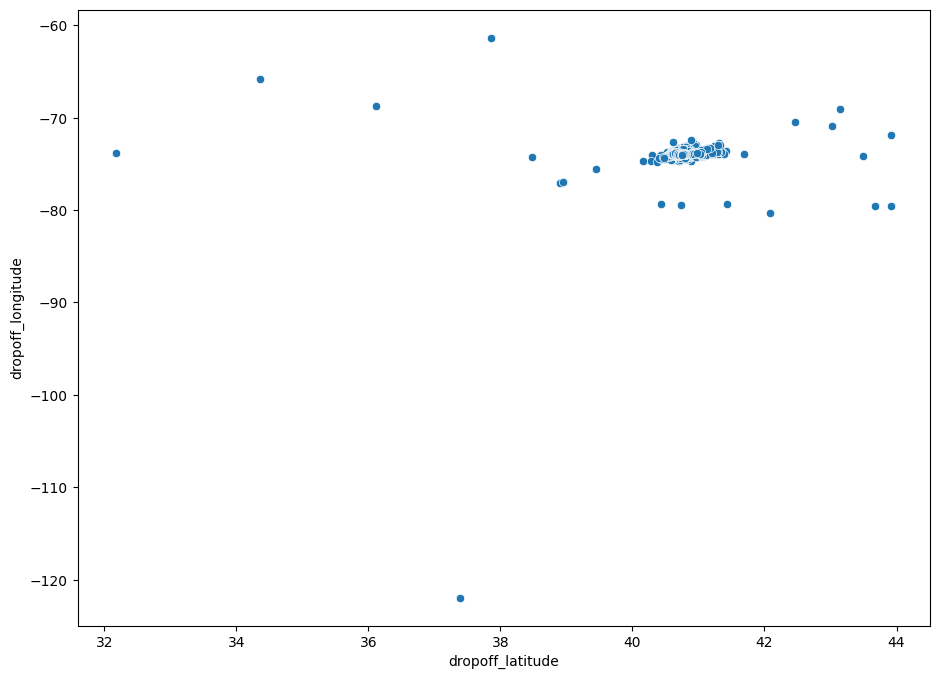

In [7]:
plt.figure(figsize=(11, 8))
sns.scatterplot(data=df, x='dropoff_latitude', y='dropoff_longitude')

In [8]:
df = df.loc[df['trip_duration']<9000]

In [9]:
df = df[(df['dropoff_longitude'] > -74.259) & (df['dropoff_longitude'] < -73.7) &
    (df['pickup_longitude'] > -74.259) & (df['pickup_longitude'] < -73.7) &
    (df['dropoff_latitude'] > 40.477) & (df['dropoff_latitude'] < 40.917) &
     (df['pickup_latitude'] > 40.477) & (df['pickup_latitude'] < 40.917) ]

Поскольку заметны выбросы в координатах почистим их исходя из долготы и широты Нью-йорка

In [10]:
df['manhattan_distance'] = (abs(df['pickup_longitude'] - df['dropoff_longitude']) +
                             abs(df['pickup_latitude'] - df['dropoff_latitude']))

In [11]:
min_longitude, max_longitude = df['pickup_longitude'].min(), df['pickup_longitude'].max()
min_latitude, max_latitude = df['pickup_latitude'].min(), df['pickup_latitude'].max()

long_step = (max_longitude - min_longitude) / 3
lat_step = (max_latitude - min_latitude) / 3


def get_grid_cell(longitude, latitude):
    x = int((longitude - min_longitude) / long_step)
    y = int((latitude - min_latitude) / lat_step)

    return min(x, 2), min(y, 2)

df['pickup_grid'] = df.apply(lambda row: get_grid_cell(row['pickup_longitude'], row['pickup_latitude']), axis=1)
df['dropoff_grid'] = df.apply(lambda row: get_grid_cell(row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [12]:

df['trip_direction'] = list(zip(df['pickup_grid'], df['dropoff_grid']))


most_common_direction = Counter(df['trip_direction']).most_common(1)[0][0]


df['direction_encoded'] = df['trip_direction'].apply(lambda x: 1 if x == most_common_direction else 0)


In [13]:

time_combinations = df.groupby(['pickup_hour', 'day_of_week']).size()
rare_times = time_combinations[time_combinations < 100].index


df['time_bin'] = df.apply(lambda row: 'rare' if (row['pickup_hour'], row['day_of_week']) in rare_times else 'common', axis=1)


In [14]:
df[['time_bin', 'direction_encoded', 'trip_direction', 'dropoff_grid', 'pickup_grid']]

,time_bin,direction_encoded,trip_direction,dropoff_grid,pickup_grid
0,common,1,"((1, 1), (1, 1))","(1, 1)","(1, 1)"
1,common,0,"((1, 1), (1, 2))","(1, 2)","(1, 1)"
2,common,0,"((1, 2), (2, 1))","(2, 1)","(1, 2)"
3,common,1,"((1, 1), (1, 1))","(1, 1)","(1, 1)"
4,common,0,"((1, 1), (1, 2))","(1, 2)","(1, 1)"
...,...,...,...,...,...
1021045,common,1,"((1, 1), (1, 1))","(1, 1)","(1, 1)"
1021046,common,1,"((1, 1), (1, 1))","(1, 1)","(1, 1)"
1021047,common,0,"((1, 1), (1, 2))","(1, 2)","(1, 1)"
1021048,common,1,"((1, 1), (1, 1))","(1, 1)","(1, 1)"


In [15]:
df[['pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y']] = pd.DataFrame(
    [(a[0], a[1], b[0], b[1]) for (a, b) in df['trip_direction']],
    index=df.index
)

# Функция для кодирования ячейки в одномерный индекс
def encode_grid(x, y, grid_size=3):
    return x * grid_size + y

# Кодируем pickup_grid и dropoff_grid
df['pickup_encoded'] = df['pickup_grid'].apply(lambda grid: encode_grid(grid[0], grid[1]))
df['dropoff_encoded'] = df['dropoff_grid'].apply(lambda grid: encode_grid(grid[0], grid[1]))


Будем использовать манхетонское расстояние

In [16]:
df = pd.get_dummies(df, columns=['vendor_id', 'time_bin'], drop_first=True)

df = df.drop(['pickup_hour', 'day', 'store_and_fwd_flag', 'day_of_week', 'month'], axis=1)


In [17]:
df = df.drop(['pickup_grid', 'dropoff_grid', 'trip_direction'], axis=1)

# Обучение моделей

In [18]:
X = df.drop('trip_duration', axis=1)
y = df['trip_duration']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [19]:
X_train

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,manhattan_distance,direction_encoded,pickup_x,pickup_y,dropoff_x,dropoff_y,pickup_encoded,dropoff_encoded,vendor_id_2
677740,1,-73.953629,40.770912,-73.976715,40.743542,0.050457,1,1,1,1,1,4,4,True
625004,3,-73.953644,40.775261,-73.979088,40.761784,0.038921,1,1,1,1,1,4,4,True
418410,2,-73.984734,40.757629,-73.987358,40.768581,0.013577,1,1,1,1,1,4,4,True
747105,1,-73.969246,40.762768,-73.966843,40.767231,0.006866,1,1,1,1,1,4,4,True
867350,1,-73.788528,40.641361,-73.952141,40.786499,0.308750,0,2,0,1,2,6,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662654,1,-73.976151,40.781246,-73.981102,40.780914,0.005283,0,1,2,1,2,5,5,False
205070,1,-73.789032,40.641220,-73.977470,40.742420,0.289639,0,2,0,1,1,6,4,True
477642,1,-73.992264,40.746101,-74.015007,40.718090,0.050755,1,1,1,1,1,4,4,True
215014,1,-73.976151,40.785965,-73.900864,40.849159,0.138481,0,1,2,1,2,5,5,False


In [20]:
scaler = StandardScaler()

scaler.fit(X_train, y_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

Lasso_model = Lasso()

elastic = ElasticNet()

In [21]:
param_grid = {
    'alpha': [0.01, 0.1, 0.2, 0.3 ]
}

grid_model = GridSearchCV(estimator=Lasso_model, cv=3, param_grid=param_grid, verbose=2)

grid_model.fit(X_train, y_train)

predict = grid_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predict))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .........................................alpha=0.01; total time=  32.0s
[CV] END .........................................alpha=0.01; total time=  29.3s
[CV] END .........................................alpha=0.01; total time=  29.4s
[CV] END ..........................................alpha=0.1; total time=   1.9s
[CV] END ..........................................alpha=0.1; total time=   5.9s
[CV] END ..........................................alpha=0.1; total time=   1.8s
[CV] END ..........................................alpha=0.2; total time=   3.0s
[CV] END ..........................................alpha=0.2; total time=   3.2s
[CV] END ..........................................alpha=0.2; total time=   7.1s
[CV] END ..........................................alpha=0.3; total time=   2.0s
[CV] END ..........................................alpha=0.3; total time=   2.1s
[CV] END ........................................

In [22]:
rmse

419.23105603082985

In [23]:
grid_model.best_estimator_

Lasso(alpha=0.01)

In [24]:
param_grid_elastic = {
    'alpha': [0.0001, 0.001, 0.01],
    'l1_ratio': [0, 0.1, 0.5]
}

grid_model_elastic = GridSearchCV(estimator=elastic, cv=3, param_grid=param_grid_elastic, verbose=2)

grid_model_elastic.fit(X_train, y_train)

predict = grid_model_elastic.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predict))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.229e+10, tolerance: 2.058e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=0.0001, l1_ratio=0; total time=  29.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.209e+10, tolerance: 2.046e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=0.0001, l1_ratio=0; total time=  28.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.226e+10, tolerance: 2.052e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=0.0001, l1_ratio=0; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.188e+10, tolerance: 2.058e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=  36.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.167e+10, tolerance: 2.046e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=  29.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.185e+10, tolerance: 2.052e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=  29.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.887e+10, tolerance: 2.058e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END .........................alpha=0.0001, l1_ratio=0.5; total time=  30.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.859e+10, tolerance: 2.046e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END .........................alpha=0.0001, l1_ratio=0.5; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.887e+10, tolerance: 2.052e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END .........................alpha=0.0001, l1_ratio=0.5; total time=  32.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.235e+10, tolerance: 2.058e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END ............................alpha=0.001, l1_ratio=0; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.216e+10, tolerance: 2.046e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END ............................alpha=0.001, l1_ratio=0; total time=  29.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.232e+10, tolerance: 2.052e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END ............................alpha=0.001, l1_ratio=0; total time=  29.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e+10, tolerance: 2.058e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  29.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.031e+10, tolerance: 2.046e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e+10, tolerance: 2.052e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.271e+10, tolerance: 2.058e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END ..........................alpha=0.001, l1_ratio=0.5; total time=  30.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e+10, tolerance: 2.046e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END ..........................alpha=0.001, l1_ratio=0.5; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e+10, tolerance: 2.052e+07
  model = cd_fast.enet_coordinate_descent(


[CV] END ..........................alpha=0.001, l1_ratio=0.5; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.295e+10, tolerance: 2.058e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=0.01, l1_ratio=0; total time=  40.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.275e+10, tolerance: 2.046e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=0.01, l1_ratio=0; total time=  28.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.292e+10, tolerance: 2.052e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=0.01, l1_ratio=0; total time=  29.4s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=  14.9s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=  16.1s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=  15.1s
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time=  22.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time=  18.4s
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time=  18.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.817e+10, tolerance: 3.078e+07
  model = cd_fast.enet_coordinate_descent(


In [25]:
rmse

419.23113055029137

In [26]:
grid_model_elastic.best_estimator_

ElasticNet(alpha=0.0001)

В ходе работы была построена модель линейной регрессии с регуляризацией для предсказания данных. Были применены модели Lasso и ElasticNet для предотвращения переобучения за счёт использования регуляризации. Оптимальные параметры регуляризации были найдены с помощью GridSearchCV, а данные предварительно масштабированы для улучшения качества обучения.

Для оценки модели использовалась метрика RMSE, которая составила приблизительно 420. Это показывает, что предсказания модели находятся на приемлемом уровне, но есть возможность улучшить точность с помощью более сложных моделей или дополнительной обработки данных.